# Wprowadzenie  

Celem niniejszego raportu jest przeprowadzenie analizy portfela kredytowego na podstawie udostępnionych danych. Analiza obejmuje oznaczenie portfela niepracujacego, czyli identyfikację przypadków niewykonania zobowiązania (default), obliczenie miar ryzyka kredytowego (ODR) oraz modelowanie prawdopodobieństwa wystąpienia defaultu (PD) w horyzoncie 12-miesięcznym.  

Dane zawierają szczegółowe informacje dotyczące kredytów, w tym m.in. daty uruchomienia i bieżące saldo (*Start_dte, Bal_amt*), liczbę dni przeterminowania (*Dpd*), status windykacyjny (*Fl_windykacji*), wystąpienie zgonu kredytobiorców (*Fl_smierc*), oraz dane dotyczące przeterminowania w ujęciu jakościowym (*DMA*). Dodatkowo dane zawierają informacje o umorzeniach oraz założona stopa dyskontowa wynosząca 9%.  

***  

**W pierwszej części** raportu skupimy się na oznaczeniu portfela niepracującego (default) zgodnie z poniższą definicją:   

*Produkt zostaje przeklasyfikowany do portfela niepracującego jeżeli spełniony jest co najmniej jeden z poniższych warunków:*  

* *rachunek znajduje się w windykacji*,

* *przeterminowanie > 400 PLN i > 1% wartości ekspozycji przekracza 90 dni*,

* *nastąpiła śmierć wszystkich kredytobiorców.*

Ponadto oznaczymy rachunki, które powróciły do portfela pracującego (*cure*) zgodnie z poniższą definicją:  

*Rachunek oznaczany jest jako *cure* jeśli przestał spełniać definicję 
defaulta i przez 3 kolejne miesiące posiadał prawidłową obsługę tj. nie posiadał więcej niż 30 dni przeterminowania (DMA).*  

***  

**W drugiej części** raportu wyznaczymy uzyskana liczbę defaultów oraz obserwowany odsetek niewykonania zobowiązania zgodnie z definicją: $$ODR_t=\frac{\text{liczba ekspozycji, które zdefaultują w ciągu roku od momentu t}}{\text{liczba wszystkich ekspozycji w portfelu pracującym w okresie t}}$$

***  

**W trzeciej części** raportu zamodelujemy PD, czyli przypiszemy oczekiwane prawopodobieństwo wystąpienia zdarzenia default w ciągu koljenych 12 miesięcy do wybranych grup ryzyka. Podział na grupy ryzyka zostanie wybrany przez odpowiednio zamodelowane drzewo decyzyjne. 


***  

## Część I  

Zaczniemy od wczytania i analizy dostępnych danych.  
Dla spójności musimy zmienić typ danych oznaczających daty na *datetime*. Ponadto dla większej czytelności zamieniamy daty w następujący sposób: *Każdy rok jest mnożony przez 12, a następnie dodawany do numeru miesiąca, tworząc unikalny identyfikator okresu.*

In [1]:
import pandas as pd
import numpy as np
df_kredyty = pd.read_parquet("C:/Users/wojtk/OneDrive/Pulpit/studia/zastosowanie modelowania w bankowości/raport 3/dane_lista3/kredyty.parquet")
df_dma = pd.read_parquet('C:/Users/wojtk/OneDrive/Pulpit/studia/zastosowanie modelowania w bankowości/raport 3/dane_lista3/DMA.parquet')
df_um = pd.read_parquet('C:/Users/wojtk/OneDrive/Pulpit/studia/zastosowanie modelowania w bankowości/raport 3/dane_lista3/umorzenia.parquet')

df_kredyty['period_dte'] = pd.to_datetime(df_kredyty['period_dte'])
df_kredyty['start_dte'] = pd.to_datetime(df_kredyty['start_dte'])
df_dma['period_dte'] = pd.to_datetime(df_dma['period_dte'])

df_kredyty['period_id'] = 12* df_kredyty['period_dte'].dt.year + df_kredyty['period_dte'].dt.month
df_dma['period_id'] = 12* df_dma['period_dte'].dt.year + df_dma['period_dte'].dt.month

Przejdźmy teraz do identyfikacji przypadków niewykonania zobowiązań (default).  

Zgodnie z przyjętą wyżej definicją niewykonania zobowiązania (default), na podstawie danych dotyczących kredytów utworzono nową zmienną pomocniczą *fl_npl* (non-performing loan), która przyjmuje wartość:  

* **0**, gdy kredyt jest uznawany za pracujący (nie spełnia żadnego z warunków defaultu),  

* **1**, gdy kredyt kwalifikuje się jako niepracujący (spełniony został co najmniej jeden z warunków defaultu).

Sprawdzimy również czy dane są kompletne (pojawianie się wartości NaN). Dla obserwacji, w których kategoria *dma* jest nieokreślona obserwujemy, że flaga windykacji jak i flaga śmierci są równe 0. W takim przypadku nie jesteśmy w stanie określić statusu portfela dla tych obserwacji, więc usuniemy je z naszych danych. 

In [2]:
df_kredyty['fl_npl'] = 0 #dac kredyt - 0, nie dac 1 bo wtedy ktores na dole jest spelnione

df_kredyty=pd.merge(left=df_kredyty,
                      right=df_dma[['id_kredytu','period_dte','dma']],
                      left_on=['id_kredytu','period_dte'],
                     right_on=['id_kredytu','period_dte'],
                     how='left')

df_kredyty.loc[df_kredyty['fl_windykacji']==1,'fl_npl']=1 

df_kredyty.loc[df_kredyty['fl_smierc']==1,'fl_npl']=1



df_kredyty.loc[df_kredyty['dma']>90,'fl_npl']=1

In [13]:
df_kredyty.isna().sum()
df_kredyty[df_kredyty['dma'].isna()]
df_kredyty=df_kredyty.loc[df_kredyty.dma.isna()==False, :].copy()

In [14]:
from IPython.display import display
import plotly.graph_objects as go

# grupowanie po miesiącu 
tabela_npl = df_kredyty.groupby([df_kredyty['period_dte'].dt.to_period('M')])['fl_npl'].value_counts().unstack().rename(columns={0: 'Kredyty pracujące', 1: 'Kredyty niepracujące'})

tabela_npl.index = tabela_npl.index.to_timestamp()

#wykres

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=tabela_npl.index,
    y=tabela_npl['Kredyty pracujące'],
    mode='lines+markers',
    name='Kredyty pracujące',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=tabela_npl.index,
    y=tabela_npl['Kredyty niepracujące'],
    mode='lines+markers',
    name='Kredyty niepracujące',
    line=dict(color='red')
))

fig.update_layout(
    title='Liczba kredytów pracujących i niepracujących w czasie',
    xaxis_title='Data',
    yaxis_title='Liczba kredytów',
    legend_title='Typ kredytu',
    template='plotly_white',
    hovermode='x unified',
    height=600
)

fig.show()


### Podsumowanie

In [15]:
wiersz_sumaryczny = pd.DataFrame(tabela_npl.sum()).T
wiersz_sumaryczny.index = ['SUMA']
display(wiersz_sumaryczny)


fl_npl,Kredyty pracujące,Kredyty niepracujące
SUMA,95262,5600


Na podstawie danych przedstawionych na wykresie można zauważyć, że liczba kredytów pracujących utrzymywała się na stabilnym wysokim poziomie. Równocześnie liczba kredytów niepracujących pozostawała stosunkowo niska i stabilna.  

Podsumowując, w całym analizowanym okresie łączna liczba kredytów pracujących wyniosła 95 262, natomiast liczba kredytów niepracujących – 5 600, co daje udział defaultów na poziomie około 5,9%. Wskazuje to na relatywnie zdrowy portfel kredytowy z ograniczonym ryzykiem niewykonania zobowiązania.

Przejdziemy teraz do wyznaczenia *cure* w naszym portfelu. *Cure* wyznaczamy jedynie dla obserwacji, które kiedykolwiek były oznaczone jako *default*. Wyznaczone wartości wpiszemy w nową kolumne *fl_npl_adj* (adjusted non-performing loan).

In [18]:
kredyty_default_ever=df_kredyty.loc[df_kredyty.fl_npl>0, 'id_kredytu'].drop_duplicates().to_list()

df_kredyty['fl_npl_adj'] = df_kredyty.fl_npl.copy()

for kred in kredyty_default_ever:

    #moment wejścia w default
    df_kred_jeden = df_kredyty.loc[df_kredyty.id_kredytu == kred, :].sort_values('period_id').copy()
    df_kred_jeden['fl_npl_shifted'] = df_kred_jeden['fl_npl'].shift(fill_value = 0)
    period_wejscie_default = df_kred_jeden.loc[(df_kred_jeden.fl_npl == 1) & (df_kred_jeden.fl_npl_shifted == 0), 'period_id'].to_list()

    max_hist_per = df_kredyty.loc[(df_kredyty.id_kredytu == kred), 'period_id'].max()   

    # wykonujemy dla każdej daty wejścia w default (może być kilka razy)
    for i in period_wejscie_default:
        while i <= max_hist_per:
            if df_kredyty.loc[(df_kredyty.id_kredytu == kred) & (df_kredyty.period_id == i), 'fl_npl'].values[0] == 1:
                i += 1
            else:
                j = i

                while (j < i+3) & (j != max_hist_per+1):
                    df_kredyty.loc[(df_kredyty.id_kredytu == kred) & (df_kredyty.period_id == j), 'fl_npl_adj'] = 1
                    j += 1

                if j > max_hist_per:
                    i = j + 1
                else:
                    if (df_kredyty.loc[(df_kredyty.id_kredytu == kred) & (df_kredyty.period_id == j), 'fl_npl'].values[0] == 0) & (df_kredyty.loc[(df_kredyty.id_kredytu == kred) & (df_kredyty.period_id == j), 'dma'].values[0] <= 30):
                        i = max_hist_per + 1
                    else:
                        df_kredyty.loc[(df_kredyty.id_kredytu == kred) & (df_kredyty.period_id == j), 'fl_npl_adj'] = 1
                        i = j + 1

***  

## Cześć II  

Chcemy skupić się teraz na wyznaczeniu wcześniej zdefiniowanej wartości $ODR_{12}$. Potrzebne nam będzie wyznaczenie informacji o tym, czy dla danego kredytu wystąpi zdarzenie defaultu w horyzoncie 12-miesięcznym. W tym celu implementujemy podejście prognostyczne, polegające na przesuwaniu horyzontu czasowego o kolejne miesiące i obserwacji statusu *fl_npl*.   

W praktyce, dla każdego okresu t, sprawdzamy czy dany kredyt wejdzie w stan niewykonania zobowiązania (*fl_npl = 1*) w którymkolwiek z kolejnych miesięcy: t+1, t+2, ..., t+12. Operację realizujemy w pętli, iterując po wartościach z przedziału range(1, 13):  

- dla każdego przesunięcia n tworzymy pomocniczą tabelę, w której period_id zostaje zwiększone o n, co odpowiada stanowi portfela w n-tym miesiącu po bieżącym okresie,

- następnie łączymy tę tabelę z danymi głównymi (df_kredyty) po id_kredytu i przesuniętym period_id,

- efektem jest powstanie nowych kolumn: *fl_npl_1*, *fl_npl_2*, ..., *fl_npl_12*, które informują nas, czy dany kredyt stanie się niepracujący odpowiednio w 1., 2., ..., 12. miesiącu od analizowanego momentu.

In [20]:
df_kredyty_default = df_kredyty[['id_kredytu', 'period_id', 'fl_npl_adj']].copy()

for i in range(1, 13):
    df_kredyty_default['period_id_plus_' + str(i)] = df_kredyty_default.period_id + i
    
    pom = df_kredyty_default[['period_id', 'id_kredytu', 'fl_npl_adj']].copy()  
    pom = pom.rename(columns = {'fl_npl_adj': 'fl_npl_' + str(i), 'period_id': 'period_id_def_' + str(i)})

    df_kredyty_default = pd.merge(left = df_kredyty_default, 
                          right=pom, 
                          left_on=['id_kredytu', 'period_id_plus_' + str(i)], 
                          right_on=['id_kredytu', 'period_id_def_' + str(i)],                        
                          how='left')

W kolejnym etapie, dla każdej obserwacji, sumujemy wartości w kolumnach *fl_npl_1* do *fl_npl_12*. Suma tych wartości wskazuje, ile razy w analizowanym horyzoncie 12 miesięcy wystąpiło zdarzenie default.  

Na tej podstawie definiujemy nową zmienną binarną, która przyjmuje wartość:  

- **1**, jeśli w ciągu 12 kolejnych miesięcy wystąpił co najmniej jeden przypadek niewykonania zobowiązania (czyli suma fl_npl_1 do fl_npl_12 > 0),  

- **0**, jeśli kredyt pozostawał w pełni pracujący przez cały ten okres (czyli suma = 0).

In [21]:
df_kredyty_default['sum_def'] = df_kredyty_default[['fl_npl_' + str(i) for i in range(1, 13)]].sum(axis=1).apply(lambda x: 1 if x>0 else 0)

Aby zapewnić wiarygodność analizy, wprowadzamy dodatkową kolumnę pomocniczą, która sprawdza, czy dla danej obserwacji dostępne są dane o statusie defaultu w pełnym, 12-miesięcznym horyzoncie.  

W przypadkach, gdy historia jest niekompletna obserwacja zostaje oznaczona jako niepełna i wykluczona z dalszych obliczeń wskaźnika ODR. Dzięki temu unikamy błędnego zaklasyfikowania kredytu jako niespełniającego definicji defaultu tylko dlatego, że brakuje mu pełnej ścieżki obserwacyjnej.

In [24]:
df_kredyty_default['flg_default_def_avaliable'] = df_kredyty_default[['fl_npl_' + str(i) for i in range(1, 13)]].isna().sum(axis=1).apply(lambda x: 0 if x != 0 else 1)

Tworzymy kolumnę *def_12m* tylko dla tych obserwacji, dla których jesteśmy w stanie jednoznacznie ocenić wystąpienie defaultu w pełnym 12-miesięcznym horyzoncie (*flg_default_def_avaliable == 1*). Dla pozostałych przypadków przypisywana jest wartość NaN, co oznacza brak wystarczających danych do oceny.

In [33]:
df_kredyty_default['def_12m']=df_kredyty_default.apply(lambda x: x.sum_def if x.flg_default_def_avaliable==1 else np.NaN, axis=1)

Dla tak uzyskanych i opracowanych danych w tabeli pomocniczej łączymy ją z głównym zbiorem danych.  

Dzięki temu zmienna *def_12m*, która zawiera informację o wystąpieniu defaultu w ciągu 12 miesięcy, zostaje zintegrowana z bazową tabelą **df_kredyty**, pozwalając na dalsze analizy, takie jak wyznaczenie ODR czy trenowanie modeli predykcyjnych.

In [31]:
df_kredyty=pd.merge(left=df_kredyty,
                   right=df_kredyty_default[['id_kredytu','period_id','def_12m']],
                   left_on=['id_kredytu','period_id'],
                   right_on=['id_kredytu','period_id'],
                   how='left')

### Obserwowany odsetek niewykonania zobowiązania (ODR) w ciągu 12 miesięcy

In [40]:
# Obliczenia
liczba_defaultow = df_kredyty.loc[
    (df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.notna()),
    'def_12m'
].sum()

liczba_ekspozycji = df_kredyty.loc[
    (df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.notna()),
    'def_12m'
].count()

odr = df_kredyty.loc[
    (df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.notna()),
    'def_12m'
].mean()

# Pomocniczy DataFrame z wynikami
df_podsumowanie_odr = pd.DataFrame({
    'Wskaźnik': [
        'Liczba ekspozycji z defaultem w ciągu 12 miesięcy',
        'Liczba ekspozycji w portfelu pracującym z pełną obserwacją',
        'Obserwowany odsetek niewykonania zobowiązania (ODR)'
    ],
    'Wartość': [
        int(liczba_defaultow),
        int(liczba_ekspozycji),
        f"{odr:.2%}"
    ]
})

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
df_podsumowanie_odr

,Wskaźnik,Wartość
0,Liczba ekspozycji z defaultem w ciągu 12 miesięcy,3129
1,Liczba ekspozycji w portfelu pracującym z pełną obserwacją,51941
2,Obserwowany odsetek niewykonania zobowiązania (ODR),6.02%


Dla dogłębnej analizy możemy przyjrzeć się wykresowi który przedstawia ODR w czasie.

In [41]:
df_odr_miesiac = df_kredyty.loc[(df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.notna())].groupby(df_kredyty['period_dte'].dt.to_period('M'))['def_12m'].mean().reset_index()

df_odr_miesiac['period_dte'] = df_odr_miesiac['period_dte'].dt.to_timestamp()
df_odr_miesiac.rename(columns={'def_12m': 'ODR'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_odr_miesiac['period_dte'],
    y=df_odr_miesiac['ODR'],
    mode='lines+markers',
    name='ODR',
    line=dict(color='royalblue', width=2),
    marker=dict(size=6)
))


fig.update_layout(
    title='Obserwowany odsetek niewykonania zobowiązania (ODR) w czasie',
    xaxis_title='Miesiąc',
    yaxis_title='ODR',
    yaxis_tickformat='.2%',
    template='plotly_white',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

Widzimy wyraźną tendencję spadkową – od wartości przekraczających 8% w latach 2017–2018 do poziomu poniżej 5% na początku 2021 roku. W ostatnich miesiącach obserwuje się delikatne odbicie, mogące sygnalizować zmianę trendu.

***  

## Część III  

W tej części analizy skupiamy się na podziale portfela kredytowego w celu przypisania poszczególnym grupom obserwowanego prawdopodobieństwa niewykonania zobowiązania (PD). W tym celu zastosowano podejście oparte na prostym drzewie decyzyjnym.  

Na podstawie obserwacji należących do portfela pracującego i posiadających pełną ścieżkę obserwacyjną w horyzoncie 12 miesięcy, zbudujemy model regresyjny typu *DecisionTreeRegressor*. Jako predyktor wykorzystano zmienną *bal_amt*, czyli pozostała kwota do spłaty, natomiast zmienną celu stanowiła wartość *def_12m* – informująca, czy w ciągu kolejnego roku wystąpił default.  

W ramach każdej grupy wyliczono:  

- **COUNT** – liczbę ekspozycji,  

- **DEFAULT_COUNT** – liczbę przypadków defaultu,  

- **PD** – średnie prawdopodobieństwo defaultu (czyli udział def_12m = 1).  

Wynikowe grupy można traktować jako kategorie ryzyka, którym przypisano empirycznie wyznaczoną wartość PD.

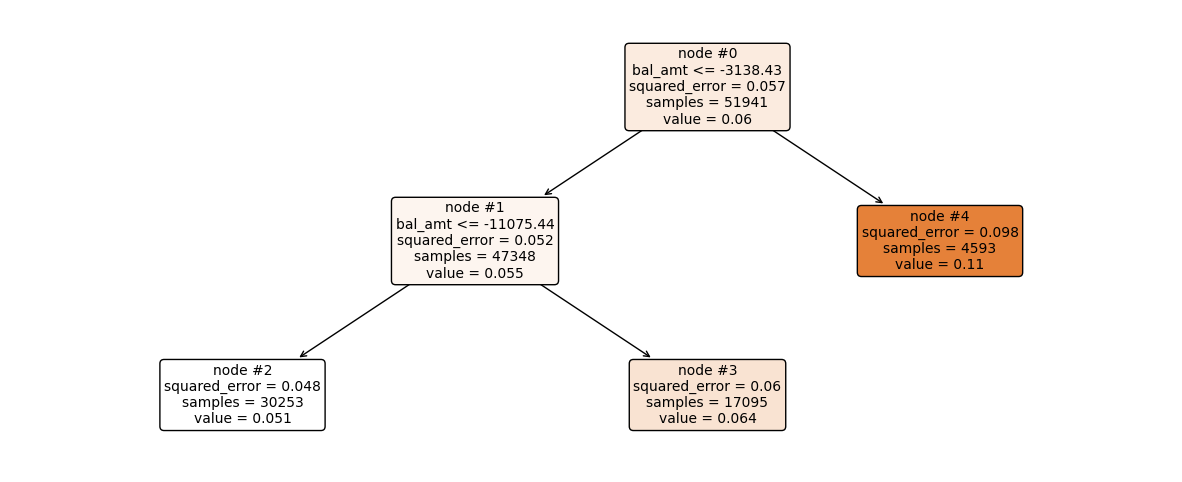

In [45]:
from sklearn import tree
X_model = df_kredyty.loc[(df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.isna()==False), ['bal_amt']].reset_index(drop=True)
Y_model = df_kredyty.loc[(df_kredyty.fl_npl_adj == 0) & (df_kredyty.def_12m.isna()==False), ['def_12m']].reset_index(drop=True)

clf = tree.DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.05)
clf = clf.fit(X=X_model, y=Y_model)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
tree.plot_tree(clf, feature_names=X_model.columns, class_names=Y_model.columns, filled=True, fontsize=10, node_ids=True, impurity=True, rounded=True)
plt.show()

In [46]:
X_model['GR'] = pd.Series(clf.apply(X_model))
X_model['def_12m'] = Y_model.copy()

X_model.groupby('GR', as_index=False).agg(COUNT = ('def_12m', 'count'), DEFAULT_COUNT = ('def_12m', 'sum'), PD = ('def_12m', 'mean'))

,GR,COUNT,DEFAULT_COUNT,PD
0,2,30253,1528.0,0.050507
1,3,17095,1094.0,0.063995
2,4,4593,507.0,0.110385


Każdy liść drzewa odpowiada jednej grupie ryzyka (GR), a średnia wartość węzła reprezentuje empiryczne prawdopodobieństwo wystąpienia niewykonania zobowiązania (PD) dla danej grupy. W szczególności:  

- Obserwaccje o niskim saldzie (≤ 3 138 zł) charakteryzują się najniższym PD (ok. 5,1%),  

- Obserwacje średnie (3 138 zł – 10 755 zł) mają nieco wyższe ryzyko (6,4%),  

- Obserwacje wysokie (> 10 755 zł) wyróżniają się najwyższym PD (ok. 11%).

Grupy te można traktować jako segmenty portfela o rosnącym poziomie ryzyka kredytowego, które mogą posłużyć do dalszego modelowania PD, scoringu lub alokacji kapitału według ryzyka.